In [3]:
# Run this if yfinance is not installed
# !pip install yfinance
# !conda install -y -c conda-forge tensorboard

In [74]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Specific for real data
BUFFER_SIZE = 5100 # lenght of timeseries 
BATCH_SIZE = 32 
data_dim = 32 
noise_dim = 100
data_channel = 1

In [4]:
# must be from ['dcgan', 'lsgan', 'wgan', 'wgan_gp', 'dragan', 'ragan', 'ralsgan']
# 'dcgan': standard deep convolutional GAN
# 'lsgan': least square GAN, a loss variant
# 'wgan': Wasserstein GAN, a loss variant
# 'wgan_gp': Wasserstein GAN with gradient penalty, a loss variant
# 'dragan': deep regret analytic GAN, a loss variant similar to 'wgan_gp'
# 'ragan', 'ralsgan': loss function improvements of 'dcgan' and 'lsgan' with realistic factors

choice = 'dcgan'

# Create Models

## Generator

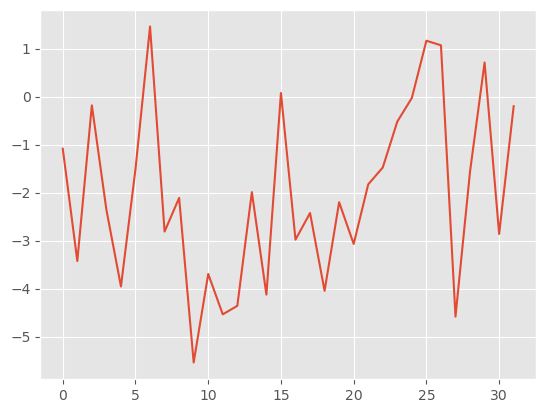

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 32]                --
├─Sequential: 1-1                        [1, 1, 32]                --
│    └─ConvTranspose1d: 2-1              [1, 1024, 2]              409,600
│    └─BatchNorm1d: 2-2                  [1, 1024, 2]              2,048
│    └─LeakyReLU: 2-3                    [1, 1024, 2]              --
│    └─ConvTranspose1d: 2-4              [1, 512, 4]               2,097,152
│    └─BatchNorm1d: 2-5                  [1, 512, 4]               1,024
│    └─LeakyReLU: 2-6                    [1, 512, 4]               --
│    └─ConvTranspose1d: 2-7              [1, 256, 8]               524,288
│    └─BatchNorm1d: 2-8                  [1, 256, 8]               512
│    └─LeakyReLU: 2-9                    [1, 256, 8]               --
│    └─ConvTranspose1d: 2-10             [1, 128, 16]              131,072
│    └─BatchNorm1d: 2-11                 [1, 128, 16]   

In [134]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.main = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, 1024, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(32, 1, kernel_size=1, stride=1, padding=16, bias=False),
            
        )

    def forward(self, z):
        z = z.view(-1, self.latent_dim, 1)
        ts = self.main(z)
        return ts


# Test the model
latent_dim = 100
z = torch.randn(1, latent_dim)
generator = Generator(latent_dim)
generated_image = generator(z)  # Generate an image

plt.plot(generated_image.detach().cpu().numpy()[0, 0, :])  # Detach from computation graph, move to CPU, and convert to numpy array for plotting
plt.show()
print(summary(generator, input_size = (1,100)))

In [107]:
z = torch.randn(1, latent_dim)
print(z.shape)
print(z.view(-1, 100, 1).shape)

torch.Size([1, 100])
torch.Size([1, 100, 1])


In [144]:
class Discriminator(nn.Module):
    def __init__(self, seq_length=32, num_channels=1):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.view(-1, 1)

# Test the model
discriminator = Discriminator()
# print(summary(discriminator, input_size = (1, 32)))
decision = discriminator(generated_image)
print (decision)

RuntimeError: Calculated padded input size per channel: (2). Kernel size: (4). Kernel size can't be greater than actual input size

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,056
│    └─Conv1d: 2-2                       128
│    └─LeakyReLU: 2-3                    --
│    └─Conv1d: 2-4                       8,192
│    └─BatchNorm1d: 2-5                  128
│    └─LeakyReLU: 2-6                    --
│    └─Conv1d: 2-7                       32,768
│    └─BatchNorm1d: 2-8                  256
│    └─LeakyReLU: 2-9                    --
│    └─Conv1d: 2-10                      262,144
│    └─BatchNorm1d: 2-11                 1,024
│    └─LeakyReLU: 2-12                   --
│    └─Conv1d: 2-13                      2,048
Total params: 307,744
Trainable params: 307,744
Non-trainable params: 0

In [87]:
generated_image.shape

torch.Size([1, 1, 258])

In [58]:
def download(ticker = "^GSPC", start_date = None, end_date = None, price = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]):
    df = yf.download(ticker, start = start_date, end = end_date)
    return df[price]

In [59]:
class YahooDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Config

In [60]:
# ticker = "AAPL, ^GSPC, AMZN"
start_date = "2023-02-01"
end_date = "2024-02-01"
price = 'Close'

batch_size = 32

# Data preparation: generating training and test datasets

In [61]:
df = download(ticker = "^GSPC", start_date = start_date, end_date = end_date, price = price)
date = df.index.strftime("%Y/%m/%d")

split_index = int(len(date)*0.8)
train = df[:split_index]
test = df[split_index:]

train = YahooDataset(train)
test = YahooDataset(test)

df.describe()

[*********************100%%**********************]  1 of 1 completed


count     251.000000
mean     4353.042036
std       249.728969
min      3855.760010
25%      4137.260010
50%      4369.009766
75%      4515.320068
max      4927.930176
Name: Close, dtype: float64

<Axes: xlabel='Date'>

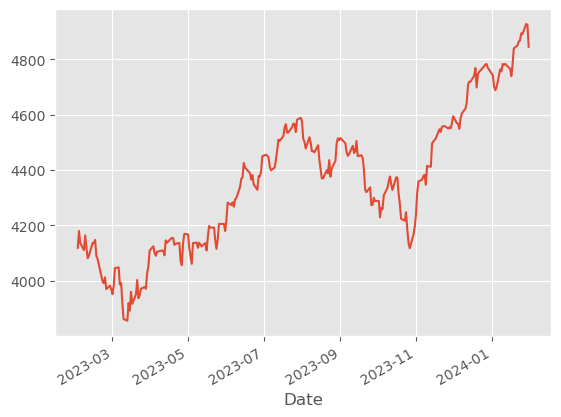

In [62]:
df.plot()

In [71]:
lr = 3e-4  # Learning rate
z_dim = 100
batch_size = 32
data_dim = 32
num_epochs = 20

In [81]:
generator = Generator(z_dim)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

In [82]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
for i, batch in enumerate(train_loader):
    print(batch.shape)

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([8])


In [83]:
for epoch in range(num_epochs):
    for i, real_data in enumerate(train_loader):
        real_data = real_data.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real data
        real_labels = torch.ones(batch_size, 1, device=device)
        real_outputs = discriminator(real_data)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_real.backward()

        # Fake data
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_data = generator(noise)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        fake_outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()

        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_data = generator(noise)
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Batch Step [{i}/{len(train_loader)}], "
                  f"Discriminator Loss: {d_loss_real.item() + d_loss_fake.item()}, "
                  f"Generator Loss: {g_loss.item()}")
        

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32]

In [75]:
batch.view(-1, 4)

tensor([[3891.9299, 4320.0601, 4278.0000, 4193.7998],
        [4147.6001, 4137.0400, 4415.2402, 4108.9399]], dtype=torch.float64)

In [74]:
batch

tensor([3891.9299, 4320.0601, 4278.0000, 4193.7998, 4147.6001, 4137.0400,
        4415.2402, 4108.9399], dtype=torch.float64)